In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.ensemble import IsolationForest

Mozemo zakljuciti da postoji kolona pod nazivom "Unnamed 32", koja ima sve NULL vrednosti i kao takva nam
predstavlja smetnju i mozemo je ukloniti iz skupa. Takodje kolona "id" nema nikakvu povezanost sa
koncanom vrednoscu skupa, tako i nju kao takvu mozemo ukloniti.

In [172]:
cancer = pd.read_csv('Cancer_Data.csv')
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [173]:
cancer = cancer.drop(['id', 'Unnamed: 32'], axis = 1)
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Mozemo zakljuciti da nema nestalih vrednosti ostalo je jos da proverimo da li ima duplikata i da zamenimo stringove u brojeve.

In [174]:

cancer['diagnosis'] = cancer['diagnosis'].replace({'M':1,'B':0})
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

C:\Users\Korisnik\AppData\Local\Temp\ipykernel_7924\680516308.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cancer['diagnosis'] = cancer['diagnosis'].replace({'M':1,'B':0})


In [175]:
cancer.duplicated().sum()


0

Da bismo proverili anomalije u skupu postoje dve metode koje cu koristi: Z-score i IsolationForest algoritam

In [176]:
import pandas as pd
import numpy as np

def zscore_anomalije(df, threshold):

    numeric_columns = df.select_dtypes(include='number').columns
    z_scores = np.abs(df[numeric_columns].apply(lambda x: (x - x.mean()) / x.std()))
    outlier_indices = np.where(np.any(z_scores > threshold, axis=1))[0]
    
    
    anomalies = df.iloc[outlier_indices]
    
    
    df_cleaned = df.drop(outlier_indices)
    
    return df_cleaned, anomalies


cancer_cleaned, anomalies = zscore_anomalije(cancer, threshold=4)


print(f"broj anomalija: {len(anomalies)}")
print(cancer_cleaned.shape,cancer.shape,anomalies.shape)


broj anomalija: 34
(535, 31) (569, 31) (34, 31)


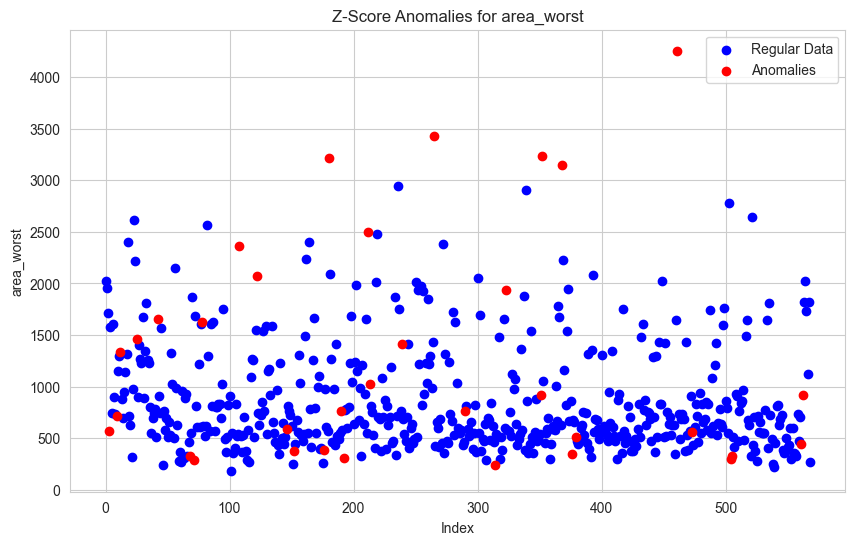

In [177]:
import matplotlib.pyplot as plt

# Specify the column name you want to analyze
column_name = 'area_worst'

# Plotting z-score anomalies for the specified column
plt.figure(figsize=(10, 6))
plt.scatter(cancer_cleaned.index, cancer_cleaned[column_name], color='blue', label='Regular Data')
plt.scatter(anomalies.index, anomalies[column_name], color='red', label='Anomalies')
plt.xlabel('Index')
plt.ylabel(column_name)
plt.title('Z-Score Anomalies for {}'.format(column_name))
plt.legend()
plt.show()


Vidimo da vrednosti koje vidno treba da budu oznacene crvenom bojom i jesu. Napomena: Neke tacke u sredini su crvene zato sto se ovde plotuje cela kolona dataframe: "anomalije", a ne mora da znaci da je taj ceo red bio izbacen zbog tog atributa

In [180]:
iso_cancer = cancer.select_dtypes(include=['number'])
print(iso_cancer.shape)
iso_forest = IsolationForest(contamination=0.05) 
preds = iso_forest.fit_predict(iso_cancer)
anomalije_iso = iso_cancer[preds == -1]
anomalije_iso.shape

(569, 31)


(29, 31)

In [181]:
dataset_cleaned_iso = cancer[preds != -1]
dataset_cleaned_iso.shape

(540, 31)

Vidimo da nam je iso algoritam ostavio malo veci broj podataka tako da cemo raditi sa njim, u slucaju da rezultati ne budu dobri, pokusacemo sa Z-score podacima

In [182]:
dataset_cleaned_iso.to_csv('cleaned_data.csv', index=False)